In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Tripolar grid

Definitions and constructing formulas for a bipolar grid from Murray's 1996 paper (R.J. Murray, Explicit Generation of Orthogonal Grids for Ocean Models, Journal of Computational Physics 126, 251-273 (1996))

Points on the grid sphere 

$\lambda_c$ and $\phi_c$ are the longitude and latitude of the point X on the spherical grid.

$\lambda_s$ and $\phi_s$ are the longitude and latitude of the point X on the projected-re-projected bipolar grid.

$\Phi_P$    is the latitude of the bounding parallel of bipolar grid (tripolar N cap).

$\lambda_0$ is the longitude of the rotated (bipolar) equator (longitude of the displaced pole).

In [34]:
#General imports and definitions
import numpy as np
import matplotlib.pyplot as plt
PI_180 = np.pi/180.

#utility function to plot grids 
def plot_grid(lon_grid,lat_grid, grid_x,grid_y,lon0=0,lat0=0,dlon=20,dlat=20,coastline=False):
    from mpl_toolkits.basemap import Basemap
    import matplotlib
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,7))
    # You can set negative contours to be solid instead of dashed:
    matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    map = Basemap(projection='npstere',boundinglat=lat0,lon_0=lon0,resolution='l')
    mx,my = map(lon_grid,lat_grid)
    #print(np.shape(x), np.shape(y)) #(239, 2881) (239, 2881)
    cs_x = map.contour(mx,my, grid_y,colors='k',linewidths=1.0, levels=np.arange(lat0, 90, dlon))
    cs_y = map.contour(mx,my, grid_x,colors='r',linewidths=1.0, levels=np.arange(lon0, lon0+360, dlat))
    plt.clabel(cs_y, inline=1, fontsize=10)
    plt.clabel(cs_x, inline=1, fontsize=10)
    if(coastline) :
        map.drawcoastlines()   

def atan2(x,y):
    angle = np.arctan( x / y )
    angle2 = np.where( x>0, angle+np.pi, angle-np.pi )
    return np.where( y>0, angle, angle2)

In [89]:
#tripolar grid quantities
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
lon_p=-300. # longitude of the displaced pole(s)
lat_p=61.247692871618455 #mercator.y.max()
lenlon=360. 
lenlat=90.0-lat_p
nxtot=1440*refine
ny_ncap=119*refine

## MIDAS

### MIDAS call

In [90]:
from pymidas.rectgrid_gen import supergrid
tripolar_n=supergrid(nx,ny_ncap,'spherical','degrees',lat_p,lenlat,lon_p,lenlon,tripolar_n=True)
tripolar_n.grid_metrics()
tripolar_n.write_nc('ncap_supergrid.nc')
print ("generated a tripolar supergrid of size (ny,nx)= ",tripolar_n.y.shape[0]-1,tripolar_n.y.shape[1]-1)
print ("tripolar grid starting longitude = ",tripolar_n.x[0,0])
print ("tripolar grid starting latitude = ",tripolar_n.y[0,0])
print (np.shape(tripolar_n.x) , np.shape(tripolar_n.y))

generated a tripolar supergrid of size (ny,nx)=  238 2880
tripolar grid starting longitude =  -300.0
tripolar grid starting latitude =  61.24769287161847
(239, 2881) (239, 2881)


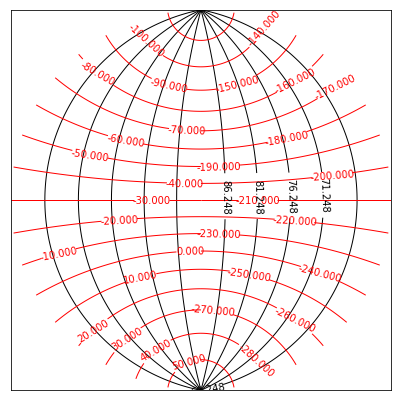

In [91]:
plot_grid(tripolar_n.x, tripolar_n.y, sp_grid_x,sp_grid_y,lon0=lon_p, lat0=lat_p, dlat=10, dlon=5)

### MIDAS algorithm based on Murray 96

$\lambda_c$ and $\phi_c$ are longitude and latitude of the point X on the spherical grid.

$\lambda_s$ and $\phi_s$ are longitude and latitude of the point X on the projected-re-projected dipolar grid.

$\Phi_P$ is  the latitude of the bounding parallel of the tripolar cap.

$\lambda_0$ is the longitude of the rotated (bipolar) equator (i.e., the longitude of the displaced pole).

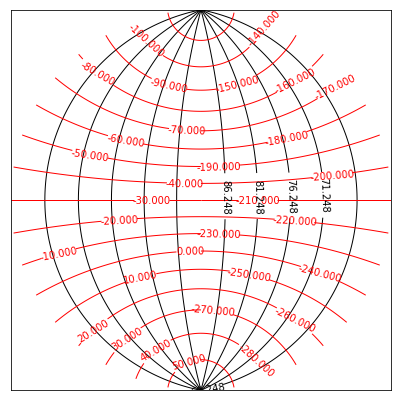

In [92]:
#Spherical grid 
nytot = ny_ncap
nxtot = nx
leny=lenlat
lenx=lenlon
jindp=np.arange(nytot+1);iindp=np.arange(nxtot+1)        
sp_y=lat_p+jindp*leny/nytot  #array([61.24769287, 61.36850088, ..., 89.87919199, 90.  ])
sp_x=lon_p+iindp*lenx/nxtot 
sp_grid_x = np.tile(sp_x,(nytot+1,1)) #(239, 2881)
sp_grid_y = np.tile(sp_y.reshape((nytot+1,1)),(1,nxtot+1)) #(239, 2881)

def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  a=np.mod(x1-x2+720.,360.)
  b=np.mod(x2-x1+720.,360.)
  d=np.minimum(a,b)
  return d

rp=np.tan(0.5*(0.5*np.pi - (sp_grid_y[0])*PI_180)) #Murray section 2.2 before Eq(6) r_p=tan(\phi_P\prime /2) 
                                                   #where \phi_P is the latitude of the bounding parrallel lat0
##MIDAS lon,lat=self.tp_trans():
##MIDAS lamc=self.bp_lon() #Why is this lon?
chi=2.0*np.arctan(np.tan(0.5*(0.5*np.pi-sp_grid_y*PI_180))/rp) #Murray Inverse of Eq(5b) 
#lamc = 0.5*np.pi - chi  #Why??????????
#lamc[:,:(nxtot//2)] = lamc[:,:(nxtot//2)] - np.pi/2
#lamc[:,(nxtot//2):] =-lamc[:,(nxtot//2):] + np.pi/2
#OR equivalently
lamc = - chi  #Why??????????
lamc[:,:(nxtot//2)] =  lamc[:,:(nxtot//2)] 
lamc[:,(nxtot//2):] =- lamc[:,(nxtot//2):] 
##phic=self.bp_colat() #Why is this co-lat in  MIDAS?
phic=mdist(sp_grid_x,lon_p) *PI_180
##phic=(sp_grid_x-lon0) *PI_180 
chic =np.arccos(np.sin(phic)*np.cos(lamc))    #Murray Eq(6) assuming phic is 90-phic !! ***********??
#chic =np.arccos(np.cos(phic)*np.cos(lamc))    #Murray Eq(6) the grid does not make sense !!
tp_grid_y = 90 - np.arctan(rp*np.tan(chic/2.0)) * 2/PI_180 #Murray Eq(5b) for \phi_s
tp_grid_x = np.arctan(np.tan(phic)*np.sin(lamc)) /PI_180   #Murray part of Eq(5a)  assuming phic is 90-phic !!
#The following gymnastics in Midas is missing from Murray paper. 
#Does this accomplish 90-atan(sin(\lambda_c)tan(\phi_c))?
tp_grid_x[:,:nxtot//4]=-tp_grid_x[:,:nxtot//4]
tp_grid_x[:,nxtot//4]=90.0
tp_grid_x[:,nxtot//4+1:nxtot//2]=180.0-tp_grid_x[:,nxtot//4+1:nxtot//2]
tp_grid_x[:,nxtot//2]=180.
tp_grid_x[:,nxtot//2+1:3*nxtot//4]=180.0-tp_grid_x[:,nxtot//2+1:3*nxtot//4]
tp_grid_x[:,3*nxtot//4]=270.
tp_grid_x[:,3*nxtot//4+1:]=360.-tp_grid_x[:,3*nxtot//4+1:]
tp_grid_x = tp_grid_x + lon_p #Murray part of Eq(5a)  

plot_grid( tp_grid_x,tp_grid_y, sp_grid_x,sp_grid_y,lon0=lon_p, lat0=lat_p, dlat=10, dlon=5)

### Alternative to Murray 96 


Here we construct the bipolar cap grid using a geometric method different from but inspired by Murray96.

First consider a globe of radius $r$ with the regular lon,lat grid but the grid circles rotated by 90 degrees around an axis that crosses the equator at the longitude $\lambda_P+90$, where $\lambda_P$ is the desired longitude of the displaced bi-poles (-300 in MIDAS construction). We denote these sets by $\Lambda_g$ and  $\Phi_g$.

Next we do a stereographic projection $P_r$ of the these two sets of circles onto a plane tangent at the North pole. The resulting two sets of curves form a curvilinear orthogonal coordinate patch for the globe with two poles located at the equator with longitudes $\lambda_P$ and$\lambda_P+180$. We denote these sets by $\Lambda_c$ and  $\Phi_c$.

Finally we do an inverse stereographic projection $P_R^{-1}$ of these curvilinear coordinate curves back on a sphere with a larger radius $R$ to relocate the poles to the desired latitude of the bipolar grid $\phi_P$. We denote these sets by $\Lambda_s$ and  $\Phi_s$, they form the desired orthogonal bipolar coordinate patch for the North cap.

So, schematically: $(\Lambda_s,\Phi_s) = P_R^{-1}(\Lambda_c,\Phi_c)=P_R^{-1}(P_r(\Lambda_g,\Phi_g)))$

The equations for the globe circles in part (1) are obtained as follows:
 
Assume a simple lon,lat coordinates on the globe:

\begin{align}
\lambda_g &= \lambda_p + i {360\over N_x} \\
\phi_g    &= j {180\over N_y}
\end{align}

 
  $\Lambda_g$ : The set of great circles with the common axis that crosses the equator at longitude $\lambda_P$. These are formed by the intersection of planes through origin with unit normal vectors ${\bf u} = ( 0,\sin\phi_g , \cos\phi_g)$ and the globe, where $\phi_g$ is the angle between ${\bf u}$ and y axis assuming we set $x$ axis in the direction of $\lambda_P$. So they obey ${\bf u} {\bf .}  (\cos\phi \cos(\lambda-\lambda_P),\cos\phi \sin(\lambda-\lambda_P),\sin\phi )=0$ which gives: 
  
\begin{align}  
\tan\phi=-\tan\phi_g \sin(\lambda-\lambda_P).
\end{align}
  
 $\Phi_g$ : The set of parallel circles with the same axis as above. 
These are formed by the intersection of planes perpendicular to the axis of the great circles above with unit normal vectors ${\bf u} = ( 1, 0, 0)$ and the globe, we set $x$ axis in the direction of $\lambda_P$. So, they obey:

\begin{align} 
\cos\phi \cos(\lambda-\lambda_P) = \cos(\lambda_g-\lambda_P).
\end{align}

The curvilinear coordinate patch $(\lambda_c,\phi_c)$ is obtained by solving the above two equations simultaneously: 

\begin{align}
{\sin(\lambda_c-\lambda_P) \over \tan\phi_c} &= -{1\over\tan\phi_g}      \equiv \beta\\
{\cos(\lambda_c-\lambda_P) \cos\phi_c}       &=  \cos(\lambda_g-\lambda_P)\equiv  \alpha
\end{align}

which gives:

\begin{align}
 \phi_c &= \sin^{-1}\left[ \left({1-\alpha^2 \over 1+\beta^2}\right)^{1/2} \right]\\
 \lambda_c &= \sin^{-1}\left[ \left(\beta^2{1-\alpha^2 \over \alpha^2+\beta^2} \right)^{1/2} \right]
\end{align}

Now to achieve the inverse projection we only need to observe a simple relation between the angels in the geometric construction (we need a figure to show this): 

\begin{align}
\tan({(90-\phi_s)\over 2}) &= \tan({(90-\phi_P) \over 2}) \tan({(90-\phi_c) \over 2})\\
\lambda_s &= \lambda_c
\end{align}

and so:

\begin{align}
\phi_s &= 90 - 2 \tan^{-1}\left( r_p \tan({(90-\phi_c) \over 2}) \right) ; \ \ r_p \equiv \tan({(90-\phi_P) \over 2}) \\
\lambda_s &= \lambda_c
\end{align}




In [108]:
#Project Northern hemisphere onto plane tangent at the North Pole
#Define a (lon,lat) spherical coordinate on the Northern hemisphere
nxtot0=1440*refine
nytot0=119*refine
long0=lon_p #strat the longitude of the grid from the longitude of the displaced pole      
latg0=0.
lenx0=360. 
leny0=90.
sp_long0 = long0 + np.arange(nxtot0+1) * lenx0/nxtot0 
sp_latg0 = latg0 + np.arange(nytot0+1) * leny0/nytot0
lamg = np.tile(sp_long0,(nytot0+1,1)) 
phig = np.tile(sp_latg0.reshape((nytot0+1,1)),(1,nxtot0+1)) 
print("lam.start",lamg[0,0],"lam.shape",lamg.shape) #(1441, 1441)
print("phi.start",phig[0,0],"phi.shape",phig.shape) #(1441, 1441)

lam.start -300.0 lam.shape (239, 2881)
phi.start 0.0 phi.shape (239, 2881)


/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply
/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


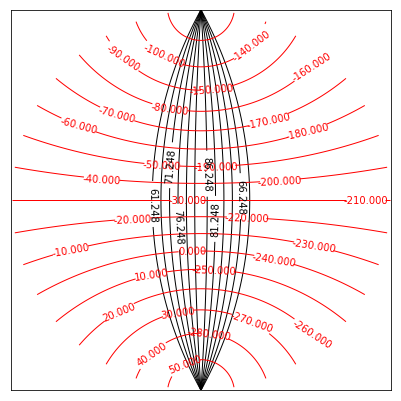

In [109]:
#Now let's combine the two 
#lon_p = 0  #Does not work for anything other than 0!
alpha = np.sin((lamg-lon_p-90)*PI_180)
beta  = 1/np.tan(phig*PI_180)
A=np.sqrt((1-alpha**2)/(1+beta**2)) 
B=np.sqrt(beta**2 * (1-alpha**2)/(alpha**2+beta**2))  #Actually two equations  +- |B|
phic = np.arcsin(A)/PI_180 
lamc = np.arcsin(B)/PI_180 
#But this equation accepts 4 solutions for a given B, {l, 180-l, l+180, 360-l } 
#We have to pickup the "correct" root. 
#One way is simply to demand lamc to be continous with lam on the equator phi=0
#I am sure there is a more mathematically concrete way to do this.
lamc = np.where((sp_long0-lon_p>90)&(sp_long0-lon_p<=180),180-lamc,lamc)
lamc = np.where((sp_long0-lon_p>180)&(sp_long0-lon_p<=270),180+lamc,lamc)
lamc = np.where((sp_long0-lon_p>270),360-lamc,lamc)
lamc = lamc + lon_p

#plot_grid(lamc,phic , lam,phi,lon0=lon_p,dlon=10);
#Now, this is important and the only place Murray96 is used in this construction
#Project back onto the larger (true) sphere so that the projected equator shrinks to latitude \phi_P=lat0_tp
#then we have tan(\phi_s'/2)=tan(\phi_p'/2)tan(\phi_c'/2)

rp=np.tan(0.5*(90-lat0_tp)*PI_180)
phis = 90 - 2 * np.arctan(rp * np.tan(0.5*(90-phic)*PI_180))/PI_180
lams = lamc

plot_grid(lams, phis, lamg,phig, lon0=lon_p, lat0=lat_p, dlat=10, dlon=5);

It looks reasonable if we plot the contours of the original lon,lat which have a greater resolution at the north cap. Which says we should have chosen the resolution of the g-grid to be the same as the desired resolution of the cap.

-300.0 61.247692871618455


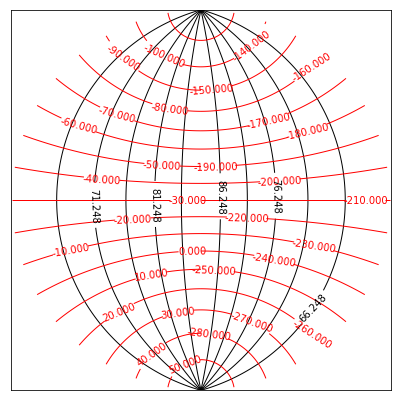

In [99]:
print(lon_p,lat_p)
plot_grid(lams,phis, sp_grid_x,sp_grid_y,lon0=lon_p,lat0=lat_p, dlat=10,dlon=5);

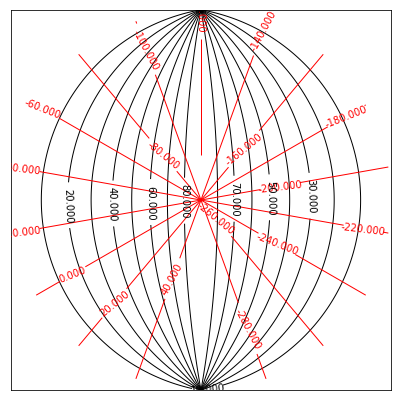

In [107]:
#Explore 
#Equations of the great circles with and axis passing through the equator at longitude lon_p (and lon_p+180)
lamc1 = lam
phic1 = -np.arctan( np.tan(phi *PI_180) * np.sin((lam-lon_p)*PI_180)) /PI_180
phic1 = np.abs(phic1)
plot_grid(lamc1,phic1 , lam,phi,lon0=lon_p, dlon=10);

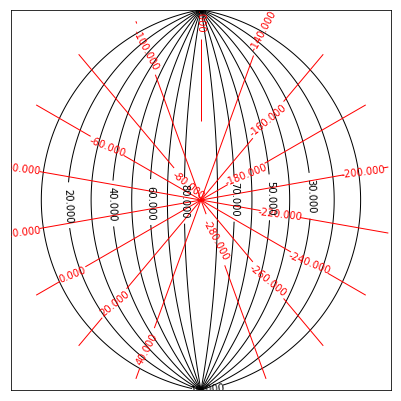

In [94]:
#Explore
#Equations of the great circles with and axis passing through the equator at longitude lon_p (and lon_p+180)
lamc1 = lam
phic1 = np.arctan( np.tan(phi *PI_180) * np.cos((lam-lon_p-90)*PI_180)) /PI_180
phic1 = np.abs(phic1)
plot_grid(lamc1,phic1 , lam,phi,lon0=lon_p, dlon=10);

/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in arccos
  app.launch_new_instance()


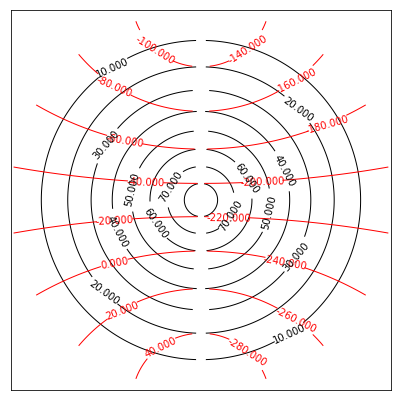

In [95]:
#Equations of the parallels with axis passing through the equator at longitude lon_p (and lon_p+180)
epsilon = 0.001
lamc2 = lon_p - np.sign(lam-lon_p-epsilon-180) * np.arccos(np.cos((lam-lon_p)*PI_180)/np.cos(phi*PI_180)) /PI_180
phic2 = phi
plot_grid(lamc2,phic2 , lam,phi,lon0=lon_p,dlon=10);

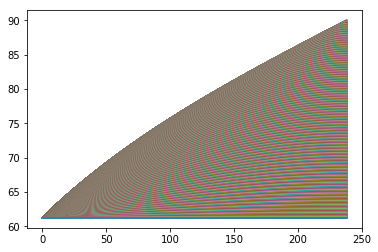

In [100]:
plt.plot(phis);

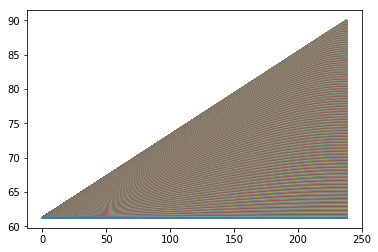

In [101]:
plt.plot(tripolar_n.y);

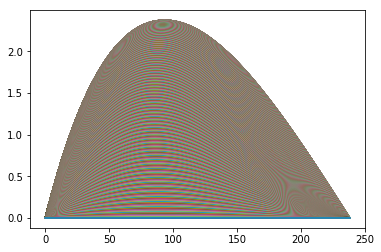

In [102]:
plt.plot(phis-tripolar_n.y);